In [1]:
import numpy as np
import time
from PIL import Image

In [2]:
def load_obj(path):
    with open(path, "r") as f:
        # 1st pass: Count mesh elements
        n_vertices, n_triangles = 0, 0
        for line in f:
            if line.startswith("v"):
                n_vertices += 1
            if line.startswith("f"):
                n_triangles += 1

        # 2nd pass: Create vertex and triangle matrices
        f.seek(0)
        V = np.zeros((n_vertices, 3), dtype=float)
        T = np.zeros((n_triangles, 3), dtype=int)
        i, j = 0, 0
        for line in f:
            if line.startswith("v"):
                s = line.split()
                assert(len(s) == 4)
                V[i] = np.array([s[1], s[2], s[3]])
                i += 1
            if line.startswith("f"):
                s = line.split()
                assert(len(s) == 4)
                T[j] = np.array([s[1], s[2], s[3]], dtype=int) - np.array([1, 1, 1])
                j += 1
        
        return V, T

In [3]:
def normalize_mesh(V):
    mean = np.mean(V, axis=0)
    radius = np.max(np.linalg.norm(V - mean, axis=1))
    return (V - mean) / radius

In [4]:
def triangle_normals(V, T):
    N = np.zeros((T.shape[0], 3))
    for i in range(T.shape[0]):
        ps = V[T[i]] # Three triangle vertex positions as row vectors
        N[i] = normalize(np.cross(ps[1] - ps[0], ps[2] - ps[0]))
        
    return N

In [5]:
def bounding_box(points, screen):
    bbmin = np.floor(np.min(points, 0)).astype('int')
    bbmax = np.ceil(np.max(points, 0)).astype('int')
    bbmin = np.clip(bbmin, [0, 0], [screen.shape[0] - 1, screen.shape[1] - 1])
    bbmax = np.clip(bbmax, [0, 0], [screen.shape[0] - 1, screen.shape[1] - 1])    
    return bbmin, bbmax

In [6]:
def backfacing(tri_points):
    # Check derminant (aka 2d cross product) of a triangle sector
    M = np.concatenate(([tri_points[1] - tri_points[0]], [tri_points[2] - tri_points[0]]))
    return np.linalg.det(M) > 0 # Screen space is left-handed

In [7]:
def point_in_triangle(p, tri_points):
    for i in range(3):
        # Compute inward-pointing 2d normal of edge
        edge = tri_points[(i + 1) % 3] - tri_points[i]
        n = np.array([-edge[1], edge[0]])
        
        # The point is inside iff it lies on the correct side of all edges
        if np.dot(n, p - tri_points[i]) > 0: # Screen space is left-handed
            return False
        
    return True

In [8]:
def normalize(v):
    return v / np.linalg.norm(v)

In [9]:
def dehomogenize(V):
    return V[:, 0:-1] / np.array([V[:, -1]]).T

In [10]:
def view_matrix(cam_pos, view_dir):
    
    world_up = np.array([0, 1, 0])
    d = normalize(np.copy(view_dir))
    right = normalize(np.cross(view_dir, world_up))
    cam_up = normalize(np.cross(right, view_dir))
    
    # Assemble look-at matrix
    T = np.identity(4)
    T[0:3, 3] = -cam_pos
    
    R = np.identity(4)
    R[0:3, 0] = right
    R[0:3, 1] = cam_up
    R[0:3, 2] = -d
    
    return R.T @ T

In [11]:
def projection_matrix(fov_deg, near, far, screen):
    # aka frustum transform   
    fov_rad = fov_deg * np.pi / 180.
    aspect_ratio = screen.shape[0] / screen.shape[1] # width/height
    
    top = near * np.tan(fov_rad / 2.)
    bottom = -top
    left = bottom * aspect_ratio
    right = top * aspect_ratio
    
    # Assemble projection matrx
    P = np.zeros((4, 4))
    P[0, 0] = 2. * near / (right - left)
    P[0, 2] = (right + left) / (right - left)
    P[1, 1] = 2. * near / (top - bottom)
    P[1, 2] = (top + bottom) / (top - bottom)
    P[2, 2] = -(far + near) / (far - near)
    P[2, 3] = -2. * far * near / (far - near)
    P[3, 2] = -1.
    
    return P

In [12]:
def vertex_shader(V, N, MV, P):
    # Switch to 4d homogeneous coordinates
    V_hom = np.append(V, np.ones((V.shape[0], 1)), axis=1)
    
    # Compute vertex positions in camera space
    # (multiplication from right because our vertices are row vectors)
    V_cam_hom = V_hom @ MV.T

    # Compute normals in camera space
    normal_transform = np.linalg.inv(MV[0:3, 0:3]).T
    N_cam = N @ normal_transform.T
    
    # Compute vertex positions in normalized device coordinates
    V_ndc_hom = V_cam_hom @ P.T
    
    return V_cam_hom, N_cam, V_ndc_hom

In [13]:
def shade_fragment(x, y, p_cam, n_cam, screen):
    ambient = np.array([32, 0, 16])
    light_dir = np.array([0, 0, 1])
    diffuse_color = np.array([255, 0, 128]) * (1. - np.max(ambient)/255)
    diffuse = np.dot(n_cam, light_dir)
    diffuse = max(0, diffuse)
    
    screen[x, y] = np.clip(diffuse_color * diffuse + ambient, 0, 255)
    #screen[x, y] = (n_cam + 1.) * 255. / 2.

In [14]:
def barycentric_coordinates(p, tri_points):
    # 2d
    a, b, c = tri_points
    denom = np.linalg.det(np.array([a-c, b-c]).T)
    alpha = np.linalg.det(np.array([p-c, b-c]).T) / denom
    beta = np.linalg.det(np.array([a-c, p-c]).T) / denom
    
    return alpha, beta, 1. - alpha - beta

In [15]:
def interpolate_perspectively(x, y, tri_points, tri_ndc_w, tri_depths, tri_values):
    alpha, beta, gamma = barycentric_coordinates(np.array([x, y]), tri_points)
    
    denom = alpha / tri_ndc_w[0] + beta / tri_ndc_w[1] + gamma / tri_ndc_w[2]
    value = np.sum(np.array([alpha, beta, gamma]) * tri_values / tri_ndc_w) / denom

    return value

In [16]:
def rasterize_and_shade(V_screen, V_ndc_w, V_depth, T, N, screen, depth):

    for i, t in enumerate(T):
        # Get screen space positions of triangle vertices (3x2 matrix)
        tri_points = V_screen[t]
        
        if backfacing(tri_points):
            continue
        
        # Compute bounding box
        bbmin, bbmax = bounding_box(tri_points, screen)
        
        # Enumerate fragments within bounding box
        for x in range(bbmin[0], bbmax[0] + 1):
            for y in range(bbmin[1], bbmax[1] + 1):
                if point_in_triangle([x, y], tri_points):

                    # Compute fragment depth
                    d = interpolate_perspectively(x + 0.5, y + 0.5, tri_points, V_ndc_w[t], V_depth[t], V_depth[t])
                    
                    # Clip vs near/far plane
                    # Depth test
                    if d >= -1 and d <= 1 and d < depth[x, y]:
                        depth[x, y] = d
                        shade_fragment(x, y, None, N[i], screen)
                    
    return screen

In [17]:
def render(V, T, N, cam_pos, loot_at, screen):
    # Clear screen
    screen[:] = np.array([64, 64, 64], dtype=np.uint8)
    depth = np.ones(screen.shape[0:2])
    
    # Get model_view and projection matrix
    MV = view_matrix(cam_pos=cam_pos, view_dir=loot_at-cam_pos)
    P = projection_matrix(fov_deg=90, near=0.01, far=100., screen=screen)
    
    # Transform vertices
    V_cam_hom, N_cam, V_ndc_hom = vertex_shader(V, N, MV, P)
    
    # Dehomogenize coordinates and store depth coordinate separately
    #V_cam = dehomogenize(V_cam_hom)
    V_ndc = dehomogenize(V_ndc_hom)
    V_ndc_w = V_ndc_hom[:, 3] # Keep homogeneous component for persp. interpolation
    V_depth = V_ndc[:, 2] # [near, far] -> [-1 ,1]
    
    # Viewport transormation
    w, h, _ = screen.shape
    V_screen = V_ndc[:, 0:2] * np.array([w / 2., -h / 2.]) + np.array([w / 2., h / 2.])
    
    # Rasterize and immediately shade fragments
    screen = rasterize_and_shade(V_screen, V_ndc_w, V_depth, T, N_cam, screen, depth)

    # Render depth buffer
    #return ((np.dstack((depth, depth, depth)) + 1.) * 127).astype('uint8')
    
    return screen

In [18]:
def test():
    # Init screen
    height = 280
    width = height * 16 // 9
    screen = np.zeros((width, height, 3), dtype=np.uint8)
    
    # Init scene
    cam_pos = np.array([0, 2, 4.]) / 4
    look_at = np.array([0.0, 0.075, 0.0])
    
    # Create cube
    #V = np.array([[-1, -1, 1], [1, -1, 1], [1, 1, 1], [-1, 1, 1], [1, -1, -1], [1, 1, -1], [-1, 1, -1]], dtype=np.float)
    #T = np.array([[0, 1, 2], [2, 3, 0], [1, 4, 5], [5, 2, 1], [2, 5, 6], [6, 3, 2]], dtype=np.int)

    #V, T = load_obj("meshes/bunny-low.obj")
    V, T = load_obj("meshes/bunny.obj")
    V = normalize_mesh(V)
    
    # Compute per-triangle normals
    N = triangle_normals(V, T)
    
    start = time.time()

    screen = render(V, T, N, cam_pos, look_at, screen)

    seconds = time.time() - start
    print("Render took %f seconds." % seconds)

    return screen

Render took 3.518796 seconds.


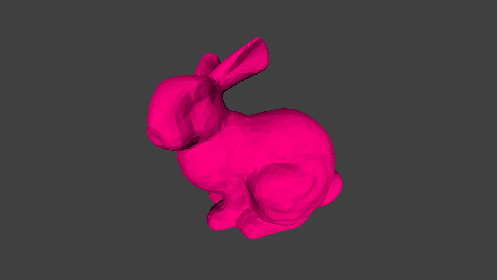

In [19]:
Image.fromarray(np.transpose(test(), (1, 0, 2)))